In [1]:
import math
import random
import numpy as np
from matplotlib import pyplot as plot

1. Build a K-NN classifier that is specifically suited for the dataset from previous exercises

In [2]:
# prepare data functions

# generates set of all possible bit patterns
# returns list of bit pattern lists
def generateDataSet(length = 2):
    result = []
    formatter = "0" + str(length) + "b"
    for i in range(2 ** length):
        result.append([int(x) for x in format(i, formatter)])
    return result

# classification rule odd = -1 even = 1
# input list of bit pattern lists
# return list
def desiredOutputOddEven(inputV):
    result = []
    for x in inputV:
        res = 1 if (int("".join(str(elem) for elem in x), 2) % 2) == 0  else -1
        result.append(res)
    return result

# return 2 sets of randomly selected elements as a sublists of a list 
def splitDataset(inputV, fraction = .3):
    inputLength = len(inputV)
    # generate list of random int without duplicates 
    randIndexes = random.sample(range(inputLength - 1), int(inputLength * fraction))
    output1 = []
    output2 = []
    for index, x in enumerate(inputV):
        if index in randIndexes:
            output1.append(x[:])
        else:
            output2.append(x[:])
    return [output1, output2]



In [3]:
# helper functions

# return Hamming distance
def getDistance(pattern1, pattern2):
    if (len(pattern1) != len(pattern1)):
        print('Patterns length missmatch!')
        return False
    matchedBits = 0
    for index, bit in enumerate(pattern1):
        if (bit != pattern2[index]):
            matchedBits += 1
    return matchedBits

# cumulative error
def calculateError (vector1, vector2):
    error = 0
    for index, v1 in enumerate(vector1):
        error += 0 if v1 == vector2[index] else 1
    return error / len(vector1)

In [4]:
# K-NN classifier
class ClassifierKNN:
    def __init__(self, inputV, outputV, k = 3):
        self.inputV = inputV
        self.outputV = outputV
        self.k = k
        
    def clasify(self, sample):
        distanseV = []
        # calculate distances to each element
        for x in self.inputV:
            distanseV.append(getDistance(x, sample))
        #print (distanseV)
        # get the closest k first indexes
        indexesOfKClosest = list(np.argsort(distanseV))[:self.k]
        #print (indexesOfKClosest)
        # get the classes for these elements
        outputs = np.array(self.outputV)
        classes = list(outputs[indexesOfKClosest])
        #print(classes)
        # evaluate the dominant class
        if sum(classes) > 0 :
            return 1
        else:
            return -1
    
    def clasifyDataset(self, sampleV):
        outputV = []
        for sample in sampleV:
            outputV.append(self.clasify(sample))
        return (outputV)

Let's run an experiment for 30 repetitions at different K

In [5]:
repeats = 30

# set of K
kV = [3,5,11]

errorsV = []

random.seed(1)

# generate dataset of 1024 10-bit elements
datas1 = generateDataSet(10)

for k in kV:
    errorSet = []
    for i in range(repeats): 
        # randomly split dataset by 50% / 50%
        splitted1 = splitDataset(datas1, 0.5)
        # dataset for training
        trainInputV = splitted1[1]
        # dataset for testing
        testInputV = splitted1[0]
        # generate desired outputs for train dataset
        trainOutputV = desiredOutputOddEven(trainInputV)
        # generate desired outputs for test dataset for comparison
        testOutputV = desiredOutputOddEven(testInputV)
        # instantiate classifier instance
        classif1 = ClassifierKNN(trainInputV, trainOutputV, k)
        # get classifier output
        classifiedOutputV = classif1.clasifyDataset(testInputV)
        # compare with desired and calculate error
        error = calculateError(testOutputV, classifiedOutputV)
        # represent error in 100% scale
        errorSet.append(error * 100)
    
    errorsV.append(errorSet)

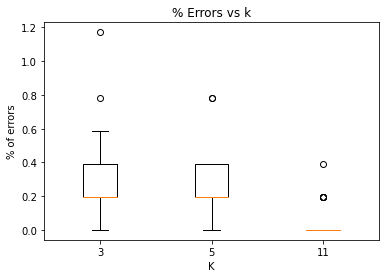

In [6]:
plot.boxplot((errorsV),labels = kV)
plot.title("% Errors vs k")
plot.ylabel("% of errors")
plot.xlabel("K")
plot.show()

As we can see from the graph, the number of errors decreases when using a larger K. I used a data separation of 50% / 50%, because with a separation of 70% / 30%, the error at K greater than 3 turned out to be zero (in fact, with the original even-odd function, the classification depends on the state of the last bit, which is a fairly primitive case).

2. Calculating Entropy and Information Gain

In [7]:
# split data set by bitNumber bit value
# return list of lists
def splitByBit(inputV, bitNumber = 0):
    output1 = []
    output2 = []
    for x in inputV:
        if x[bitNumber] > 0:
            output1.append(x[:])
        else:
            output2.append(x[:])
    return [output1, output2]

# return probabilipy of p in inputV dataset
def probabilipyP(inputV, p):
    pV = [i for i in inputV if i == p]
    return len(pV) / len(inputV)

# return entropy for dataset
def entrophy(outputV):
    prP1 = probabilipyP(outputV, 1)
    prP2 = probabilipyP(outputV, -1)
    # avoid log2(0)
    entrophy = -((prP1 * (0 if prP1 == 0 else np.log2(prP1)) + (prP2 * (0 if prP2 == 0 else np.log2(prP2)))))
    return entrophy

In [8]:
# testing part
dataset2 = generateDataSet(10)
splitted2 = splitByBit(dataset2)
splitted2 = splitDataset(dataset2, 0.3)
datasPart1 = splitted2[0]
datasPart2 = splitted2[1]

#print(probabilipyP(desiredOutputOddEven(datasPart1), 1))
#print(probabilipyP(desiredOutputOddEven(datasPart2), -1))

print(entrophy(desiredOutputOddEven(datasPart1)))
print(entrophy(desiredOutputOddEven(datasPart2)))

0.9944132844077624
0.9989768567398462


In [9]:
# return Information Gain for 2 splits by bit at position "splitBy"
def gainE(inputV, splitBy):
    #split the dataset by feature
    splittedV = splitByBit(inputV, splitBy)
    # generate outputs for datasets
    outputsV = []
    for dataset in splittedV:
        outputsV.append(desiredOutputOddEven(dataset))
    # entrophy for each splitted dataset
    entrophyV = []
    for dataset in outputsV:
        entrophyV.append(entrophy(dataset))
    # entrophy for whole dataset
    wholeEntrophy = entrophy(desiredOutputOddEven(inputV))
    # weighted average of entropy for each dataset
    entrophyWA = 0
    for index, entr in enumerate(entrophyV):
        entrophyWA += entr * len(outputsV[index])/len(inputV)
    # information gain
    gain = wholeEntrophy - entrophyWA
    return gain

Let's calculate the IG for all sets, dividing the initial data set sequentially for each feature

In [10]:
# generate dataset
dataset5 = generateDataSet(10)

for bit in range(len(dataset5[0])):
    ig = gainE(dataset5, bit)
    print("IG for dataset divided by " + str(bit) + "-th bit is " + str(ig))

IG for dataset divided by 0-th bit is 0.0
IG for dataset divided by 1-th bit is 0.0
IG for dataset divided by 2-th bit is 0.0
IG for dataset divided by 3-th bit is 0.0
IG for dataset divided by 4-th bit is 0.0
IG for dataset divided by 5-th bit is 0.0
IG for dataset divided by 6-th bit is 0.0
IG for dataset divided by 7-th bit is 0.0
IG for dataset divided by 8-th bit is 0.0
IG for dataset divided by 9-th bit is 1.0


Since we are using a perfectly balanced data set (all possible combinations), and the output values depend on the value of the last bit (even-odd function), the resulting IG data are discrete.
Now let's take, for example, a part of the entire dataset, randomly selected from the entire set (60%), which will introduce a certain unevenness (with a high probability, this set will be missing some even or odd bit patterns)

In [11]:
# generate dataset and take only 60%
dataset6 = splitDataset(generateDataSet(10), 0.6)[0]

for bit in range(len(dataset6[0])):
    ig = gainE(dataset6, bit)
    print("IG for dataset divided by " + str(bit) + "-th bit is " + str(ig))

IG for dataset divided by 0-th bit is 1.1260930968037819e-05
IG for dataset divided by 1-th bit is 7.91137040883072e-05
IG for dataset divided by 2-th bit is 0.0005169763908419167
IG for dataset divided by 3-th bit is 0.0002683148087453402
IG for dataset divided by 4-th bit is 0.0007539616606945243
IG for dataset divided by 5-th bit is 0.0005701132596442893
IG for dataset divided by 6-th bit is 2.5699077752072697e-05
IG for dataset divided by 7-th bit is 0.00043797267561052067
IG for dataset divided by 8-th bit is 0.00028390597451743993
IG for dataset divided by 9-th bit is 0.9987061487157054


As we can see, that dividing the data set on the basis of the last bit gives the maximum value of the IG. IG is a measure of the ordering of data sets divided by a certain feature (as opposed to entropy, which is a measure of disorder in the data). Thus, IG can be used to evaluate the quality of data subdivision. By sequentially dividing the data according to various features and evaluating the IG separation, it is possible to build a so-called "decision tree". In our case, this tree has only one fork, since the dataset is classified by 1 feature (the last bit).